In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sub_df = pd.read_csv("submit_sample.csv")

In [51]:
train_df.shape

(27532, 16)

In [52]:
test_df.shape

(27537, 15)

In [53]:
sub_df.shape

(27536, 2)

In [54]:
train_df.head(5)

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158


In [55]:
train_df.tail(5)

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660,clean,automatic,rwd,compact,truck,black,pa,32212
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072,clean,automatic,rwd,full-size,pickup,black,NaN,5400
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908,clean,automatic,4wd,mid-size,SUV,white,ny,22227
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326,clean,automatic,4wd,mid-size,sedan,white,ny,3054
27531,27531,orange county,2009,chevrolet,excellent,8 cylinders,gas,91813,rebuilt,automatic,rwd,full-size,van,white,ca,20801


In [56]:
test_df.head(5)

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,27532,western slope,2015,chevrolet,excellent,4 cylinders,gas,92553,clean,automatic,fwd,full-size,SUV,red,NaN
1,27533,roseburg,2013,nissan,like new,4 cylinders,gas,134385,salvage,automatic,fwd,mid-size,sedan,black,or
2,27534,akron / canton,2011,volkswagen,good,4 cylinders,gas,102489,clean,automatic,fwd,full-size,sedan,black,oh
3,27535,denver,2016,jeep,excellent,6 cylinders,diesel,64310,clean,automatic,4wd,mid-size,SUV,red,co
4,27536,hickory / lenoir,1999,honda,excellent,8 cylinders,gas,180839,rebuilt,automatic,4wd,mid-size,SUV,silver,nc


In [57]:
test_df.tail(5)

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
27532,55064,great falls,2016,gmc,excellent,6 cylinders,gas,90902,rebuilt,automatic,fwd,full-size,truck,black,mt
27533,55065,las vegas,2012,nissan,excellent,4 cylinders,gas,27234,rebuilt,automatic,fwd,mid-size,sedan,white,nv
27534,55066,phoenix,2002,bmw,excellent,6 cylinders,gas,99761,clean,automatic,rwd,full-size,coupe,blue,az
27535,55067,colorado springs,2006,bmw,excellent,6 cylinders,gas,162279,clean,automatic,4wd,mid-size,sedan,silver,co
27536,55068,syracuse,2006,jeep,excellent,6 cylinders,gas,186965,clean,automatic,4wd,full-size,SUV,black,ny


In [58]:
train_df["manufacturer"].unique()

array(['bmw', 'toyota', 'ford', 'nissan', 'volkswagen', 'FORD', 'lexus',
       'buick', 'subaru', 'ram', 'TOYOTA', 'dodge', 'ｂｍｗ', 'chevrolet',
       'RAM', 'BMW', 'jeep', 'ｃｈｅｖｒｏｌｅｔ', 'honda', 'NISSAN', 'hyundai',
       'chrysler', 'gmc', 'mazda', 'audi', 'lincoln', 'kia',
       'mercedes-benz', 'mitsubishi', 'CHEVROLET', 'GMC', 'ｆｏｒｄ', 'BUICK',
       'saturn', 'infiniti', 'MINI', 'mercury', 'cadillac',
       'MERCEDES-BENZ', 'pontiac', 'acura', 'HONDA', 'ACURA', 'KIA',
       'fiat', 'jaguar', 'ｒａｍ', 'mini', 'LEXUS', 'VOLKSWAGEN', 'ｋｉａ',
       'SUBARU', 'ｎｉｓｓａｎ', 'DODGE', 'volvo', 'HYUNDAI', 'MAZDA', 'ｈｏｎｄａ',
       'ｍａｚｄａ', 'INFINITI', 'CADILLAC', 'JEEP', 'LINCOLN', 'ｔｏｙｏｔａ',
       'niѕsan', 'AUDI', 'ＶＯＬＫＳＷＡＧＥＮ', 'ＣＨＥＶＲＯＬＥＴ', 'MERCURY', 'ｂｕｉｃｋ',
       'ROVER', 'ｄｏｄｇｅ', 'porsche', 'ｖｏｌｖｏ', 'ｖｏｌｋｓｗａｇｅｎ', 'JAGUAR',
       'SATURN', 'ｊｅｅｐ', 'rover', 'ｓｕｂａｒｕ', 'CHRYSLER', 'PONTIAC',
       'ｍｉｔｓｕｂｉｓｈｉ', 'ＴＯＹＯＴＡ', 'ＢＭＷ', 'ｃｈｒｙｓｌｅｒ', 'nisѕan', 'MITSUBISHI',
       'ｈｙｕｎｄａｉ', 'ｇｍｃ'

In [59]:
#メーカの表記ゆれを統一
import unicodedata
train_df['manufacturer'] = train_df['manufacturer'].str.upper()

# 全角英語を英語大文字に変換する関数
def convert_fullwidth_to_upper(text):
    return ''.join(unicodedata.normalize('NFKC', char).upper() for char in text)
# nameカラムの要素を英語大文字に統一します
train_df['manufacturer'] = train_df['manufacturer'].apply(convert_fullwidth_to_upper)

train_df["manufacturer"].replace("ᴄHRYSLER","CHEVROLET",inplace=True)
train_df["manufacturer"].replace("SUBΑRU","SUBARU",inplace=True)
train_df["manufacturer"].replace("TOYOTА","TOYOTA",inplace=True)
train_df["manufacturer"].replace("NIЅSAN","NISSAN",inplace=True)
train_df["manufacturer"].replace("NISЅAN","NISSAN",inplace=True)
train_df["manufacturer"].replace("SΑTURN","SATURN",inplace=True)
train_df["manufacturer"].replace("АCURA","ACURA",inplace=True)
train_df["manufacturer"].replace("VОLKSWAGEN","VOLKSWAGEN",inplace=True)
train_df["manufacturer"].replace("LEXUЅ","LEXUS",inplace=True)
# 結果を表示
print(train_df["manufacturer"].unique())



['BMW' 'TOYOTA' 'FORD' 'NISSAN' 'VOLKSWAGEN' 'LEXUS' 'BUICK' 'SUBARU'
 'RAM' 'DODGE' 'CHEVROLET' 'JEEP' 'HONDA' 'HYUNDAI' 'CHRYSLER' 'GMC'
 'MAZDA' 'AUDI' 'LINCOLN' 'KIA' 'MERCEDES-BENZ' 'MITSUBISHI' 'SATURN'
 'INFINITI' 'MINI' 'MERCURY' 'CADILLAC' 'PONTIAC' 'ACURA' 'FIAT' 'JAGUAR'
 'VOLVO' 'ROVER' 'PORSCHE' 'LAND ROVER' 'ASTON-MARTIN' 'ALFA-ROMEO']


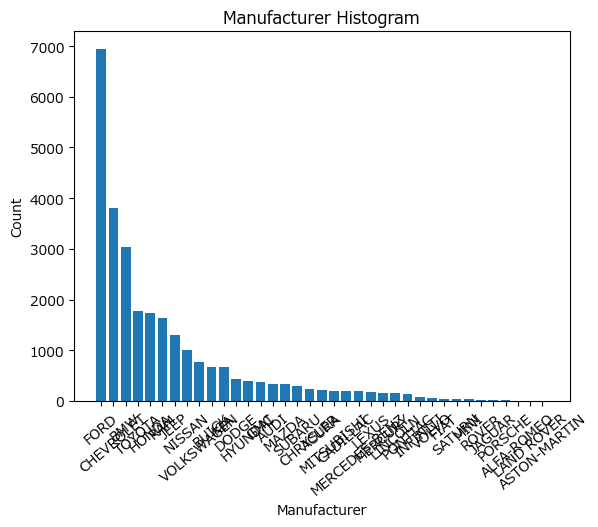

<Figure size 5000x600 with 0 Axes>

<Figure size 5000x600 with 0 Axes>

In [60]:
manufacturer_hist = train_df["manufacturer"].value_counts()

# ヒストグラムを描画
plt.bar(manufacturer_hist.index, manufacturer_hist.values)
plt.xlabel('Manufacturer')
plt.ylabel('Count')
plt.title('Manufacturer Histogram')
plt.xticks(rotation=40)
plt.show()
plt.figure(figsize=(50, 6))  

In [61]:
manufacturer_hist

FORD             6943
CHEVROLET        3808
BMW              3044
TOYOTA           1784
HONDA            1742
RAM              1639
JEEP             1297
NISSAN           1003
VOLKSWAGEN        773
BUICK             678
KIA               668
DODGE             433
HYUNDAI           391
GMC               370
AUDI              329
MAZDA             327
SUBARU            290
CHRYSLER          236
ACURA             224
MITSUBISHI        206
CADILLAC          204
MERCEDES-BENZ     199
LEXUS             187
MERCURY           155
LINCOLN           152
PONTIAC           145
INFINITI           73
VOLVO              60
FIAT               43
SATURN             42
MINI               37
ROVER              18
JAGUAR             12
PORSCHE            12
ALFA-ROMEO          4
LAND ROVER          2
ASTON-MARTIN        2
Name: manufacturer, dtype: int64

In [62]:
train_df["manufacturer"].unique()

array(['BMW', 'TOYOTA', 'FORD', 'NISSAN', 'VOLKSWAGEN', 'LEXUS', 'BUICK',
       'SUBARU', 'RAM', 'DODGE', 'CHEVROLET', 'JEEP', 'HONDA', 'HYUNDAI',
       'CHRYSLER', 'GMC', 'MAZDA', 'AUDI', 'LINCOLN', 'KIA',
       'MERCEDES-BENZ', 'MITSUBISHI', 'SATURN', 'INFINITI', 'MINI',
       'MERCURY', 'CADILLAC', 'PONTIAC', 'ACURA', 'FIAT', 'JAGUAR',
       'VOLVO', 'ROVER', 'PORSCHE', 'LAND ROVER', 'ASTON-MARTIN',
       'ALFA-ROMEO'], dtype=object)

In [63]:
train_df["state"].unique()

array([nan, 'pa', 'ks', 'ny', 'ca', 'al', 'or', 'va', 'mt', 'nj', 'ma',
       'wi', 'sc', 'wa', 'dc', 'oh', 'in', 'de', 'fl', 'nm', 'az', 'ok',
       'mn', 'co', 'nv', 'wv', 'tn', 'mi', 'ri', 'il', 'tx', 'ut', 'ia',
       'ga', 'md', 'mo', 'ky', 'nc', 'ak', 'id', 'ct', 'wy', 'nd', 'me',
       'ar', 'hi', 'sd', 'ne', 'nh', 'vt', 'la', 'ms'], dtype=object)

In [64]:

def des(X):
    # manufacturerがBMWの行のみを抽出します
    bmw_df = train_df[train_df['manufacturer'] == X]

    plt.rcParams['font.family'] = 'Meiryo'
    # ヒストグラムを作成して表示します
    plt.hist(bmw_df['price'], bins=10, edgecolor='black')
    plt.xlabel('ドル')
    plt.ylabel('count')
    plt.title('値段と販売台数')
    return plt.show()

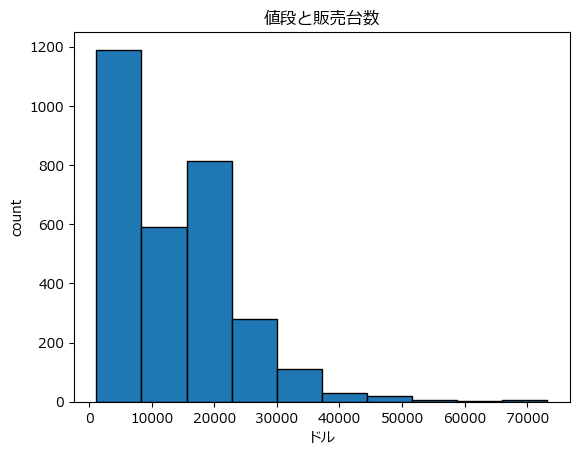

In [65]:
des("BMW")

In [66]:
manu_list=train_df["manufacturer"].unique()

In [67]:
manu_list

array(['BMW', 'TOYOTA', 'FORD', 'NISSAN', 'VOLKSWAGEN', 'LEXUS', 'BUICK',
       'SUBARU', 'RAM', 'DODGE', 'CHEVROLET', 'JEEP', 'HONDA', 'HYUNDAI',
       'CHRYSLER', 'GMC', 'MAZDA', 'AUDI', 'LINCOLN', 'KIA',
       'MERCEDES-BENZ', 'MITSUBISHI', 'SATURN', 'INFINITI', 'MINI',
       'MERCURY', 'CADILLAC', 'PONTIAC', 'ACURA', 'FIAT', 'JAGUAR',
       'VOLVO', 'ROVER', 'PORSCHE', 'LAND ROVER', 'ASTON-MARTIN',
       'ALFA-ROMEO'], dtype=object)

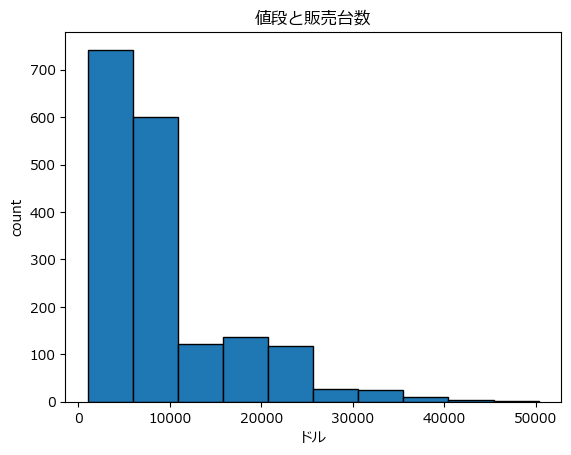

In [68]:
des("TOYOTA")
    

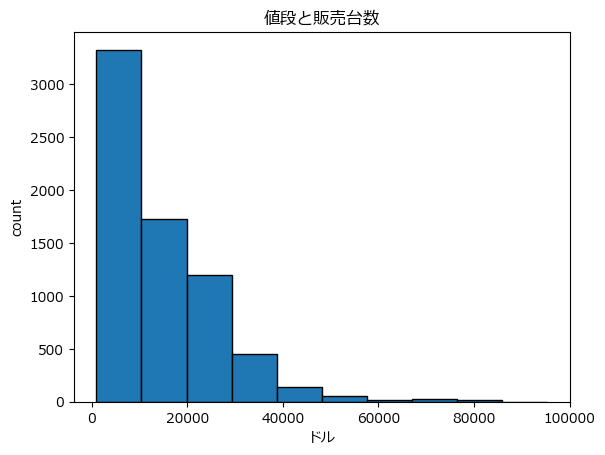

In [69]:
des("FORD")

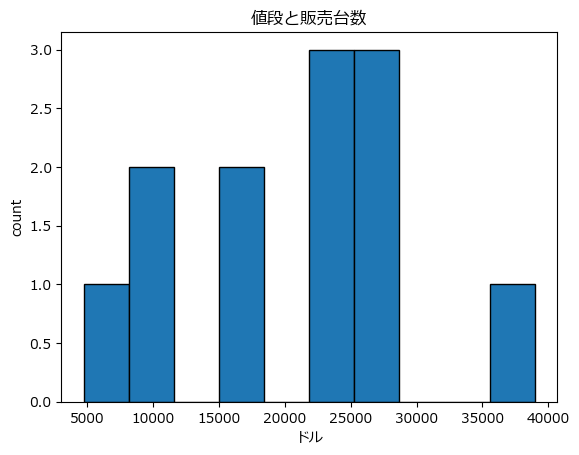

In [70]:
des("PORSCHE")

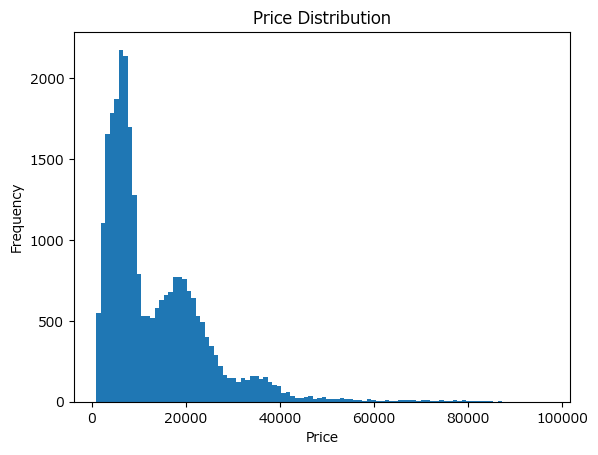

In [71]:
import matplotlib.pyplot as plt

price_data = train_df["price"]

# 1. ビンの数を指定してヒストグラムを表示
plt.hist(price_data, bins=100)

# 2. ヒストグラムを正規化して表示
# plt.hist(price_data, bins=20, density=True)

# 3. 対数軸を使用して表示
# plt.hist(price_data, bins=20, log=True)

plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Price Distribution")
plt.show()


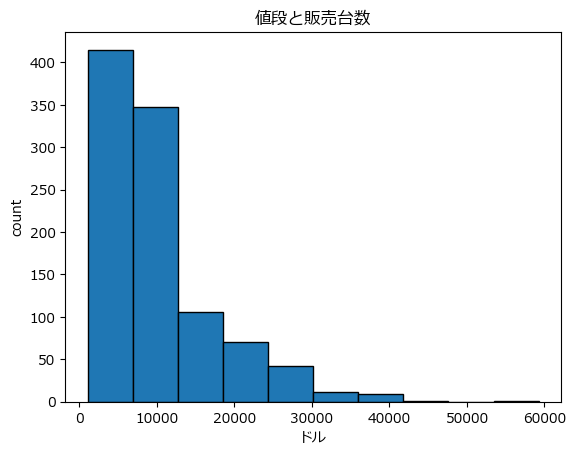

In [72]:
des('NISSAN')

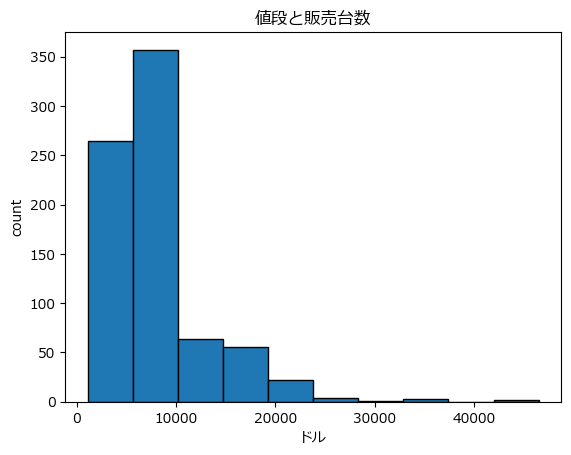

In [73]:
des('VOLKSWAGEN')

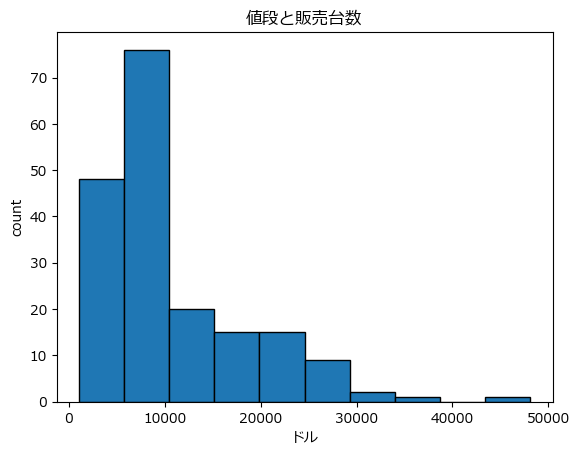

In [74]:
des('LEXUS')

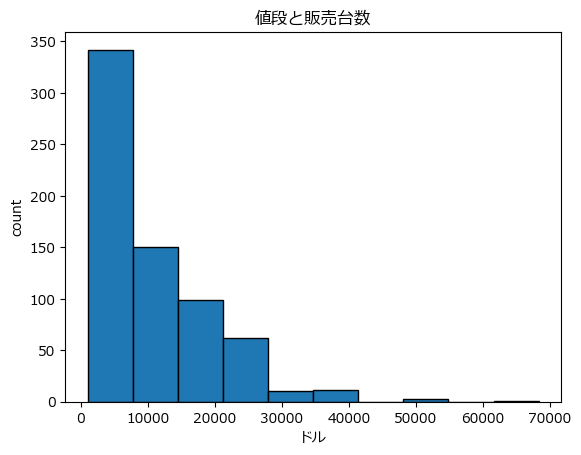

In [75]:
des('BUICK')

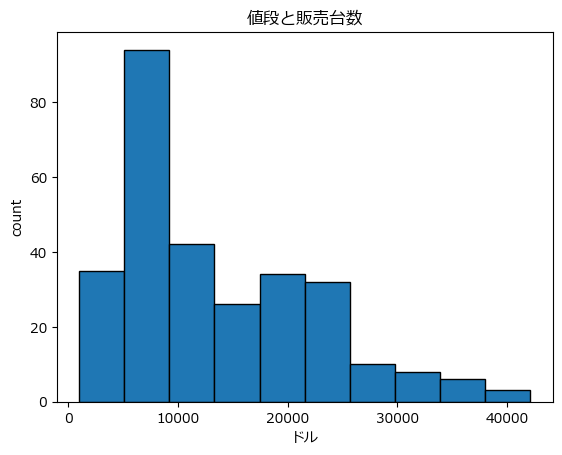

In [76]:
des("SUBARU")

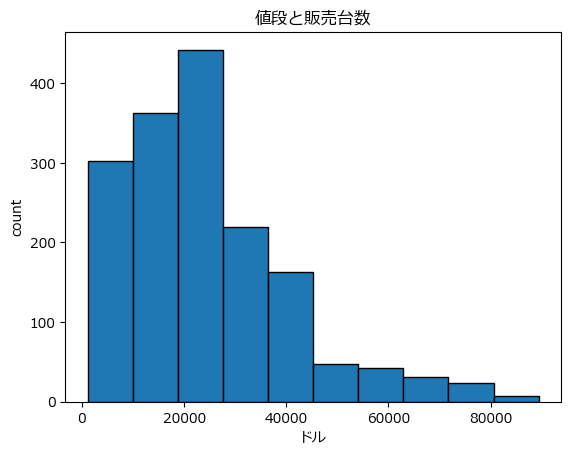

In [77]:
des('RAM')

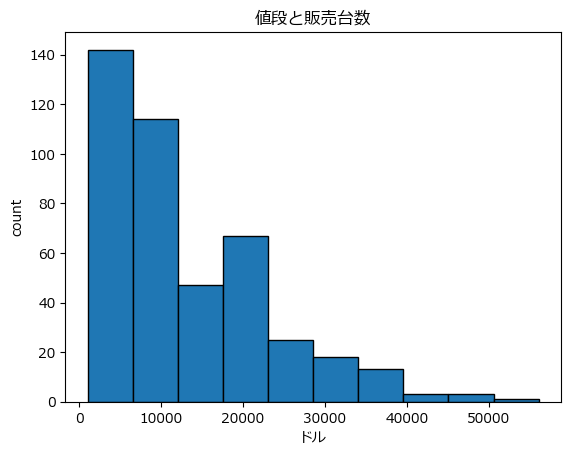

In [78]:
des( 'DODGE')

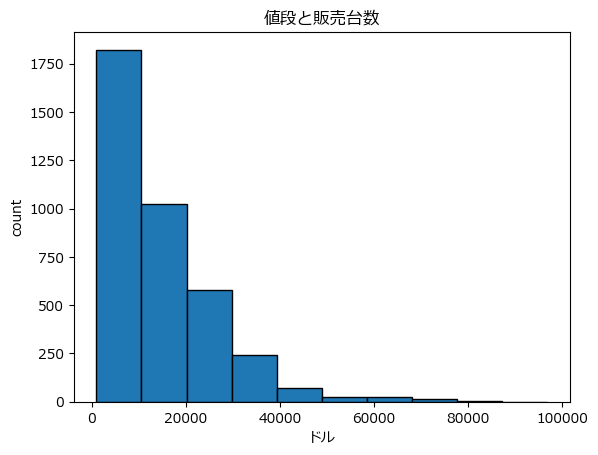

In [79]:
des('CHEVROLET')

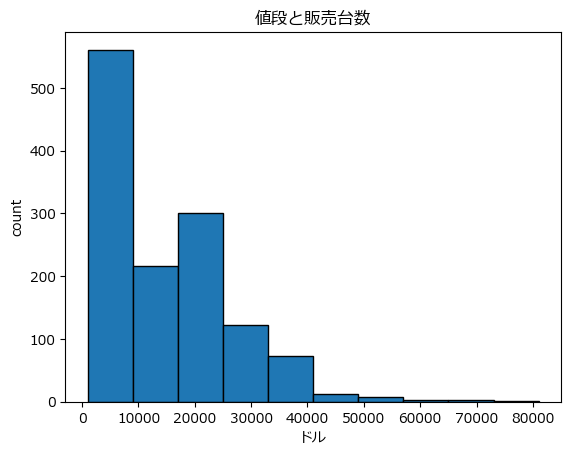

In [80]:
des('JEEP')

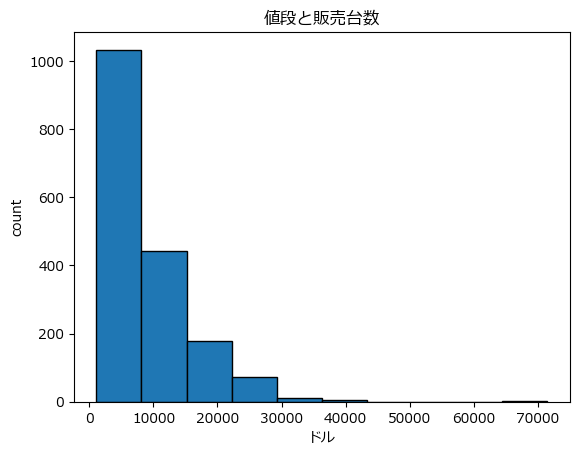

In [81]:
des('HONDA')

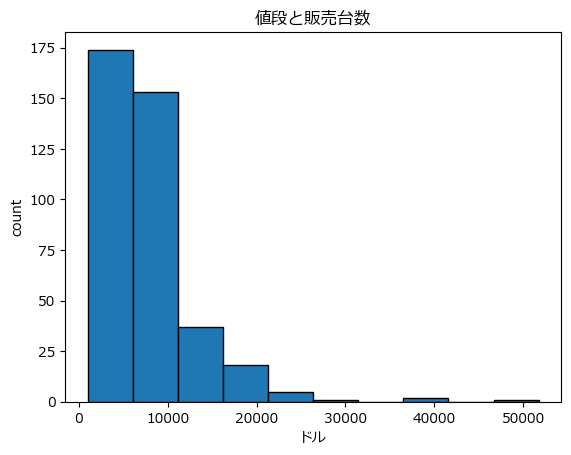

In [82]:
des('HYUNDAI')

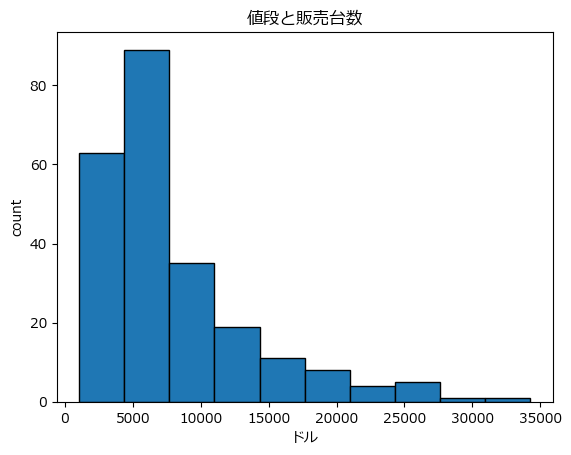

In [83]:
des('CHRYSLER')

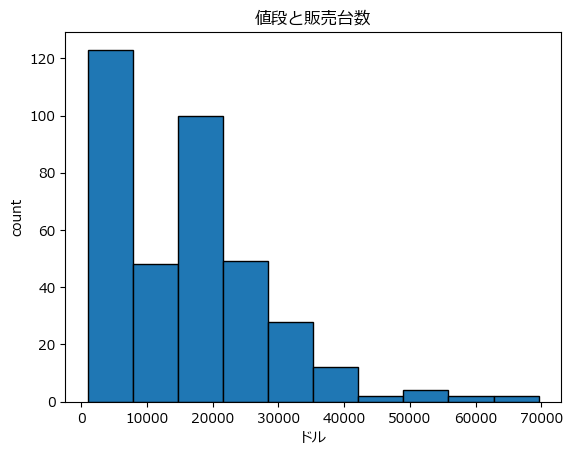

In [84]:
des("GMC")

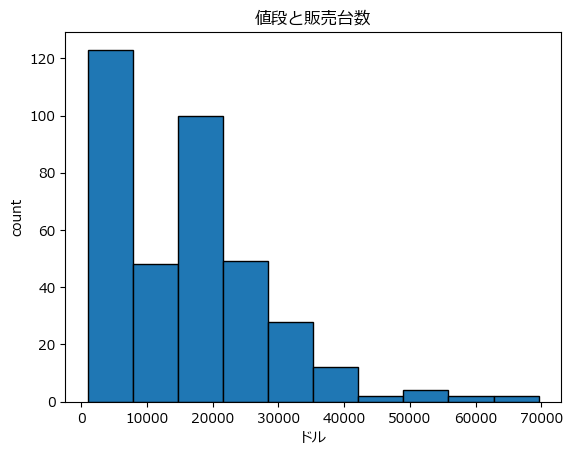

In [85]:
des("GMC")

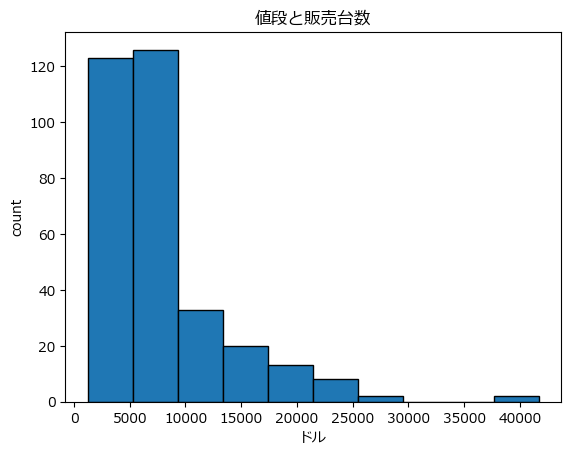

In [86]:
des('MAZDA')

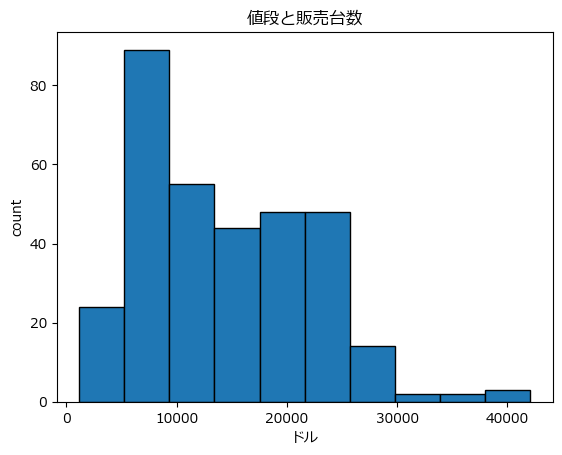

In [87]:
des('AUDI')

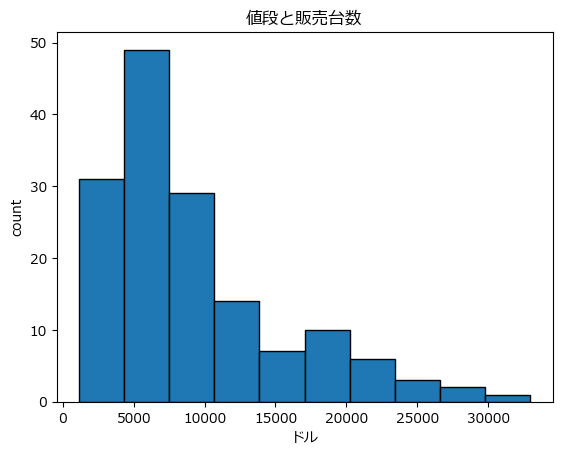

In [88]:
des('LINCOLN')

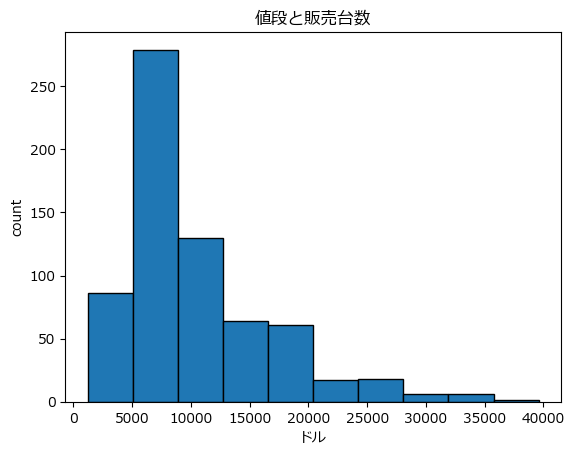

In [89]:
des('KIA')

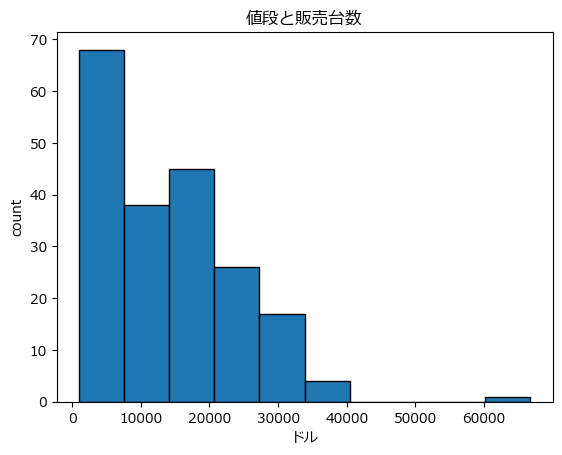

In [90]:
des('MERCEDES-BENZ')

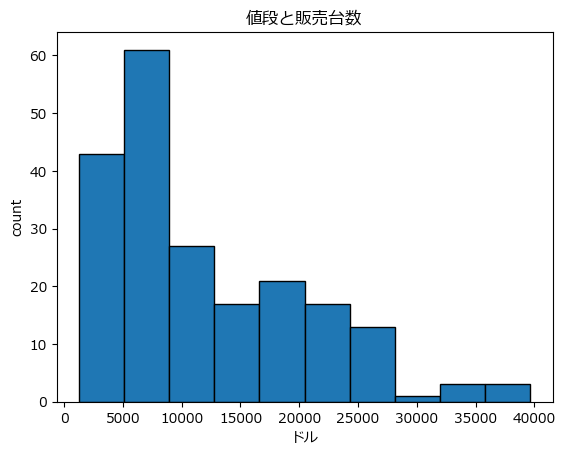

In [91]:
des('MITSUBISHI')

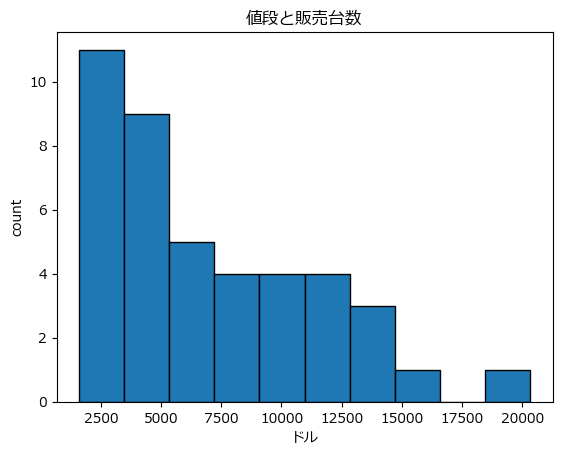

In [92]:
des('SATURN')

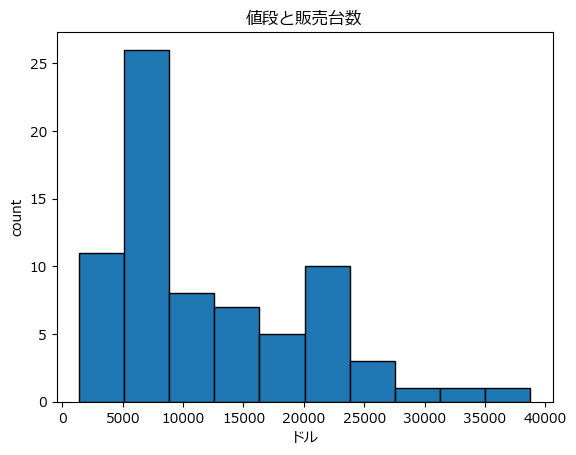

In [93]:
des('INFINITI')

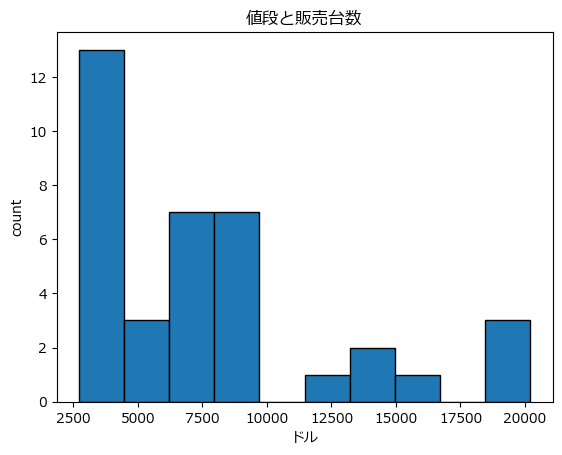

In [94]:
des('MINI')

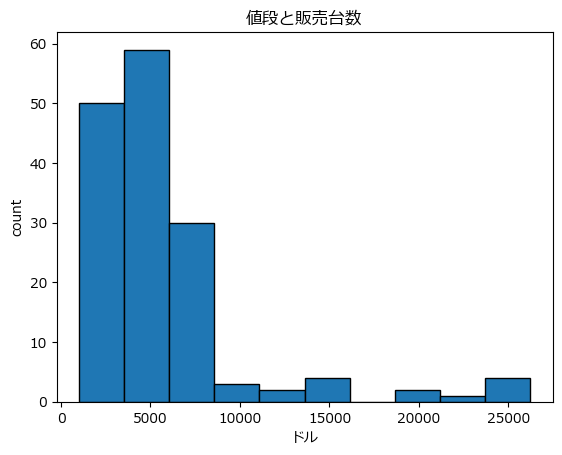

In [95]:
des('MERCURY')

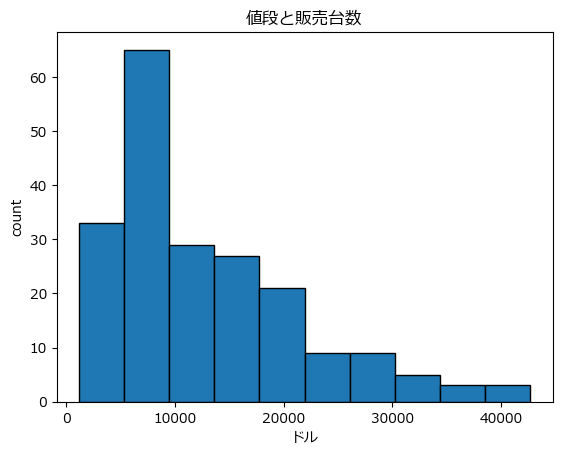

In [96]:
des('CADILLAC')

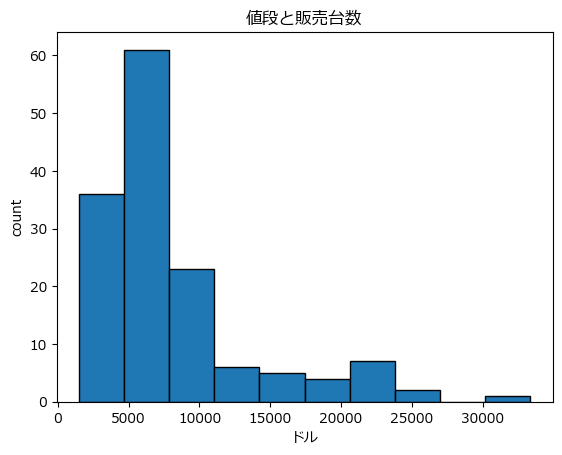

In [97]:
des('PONTIAC')

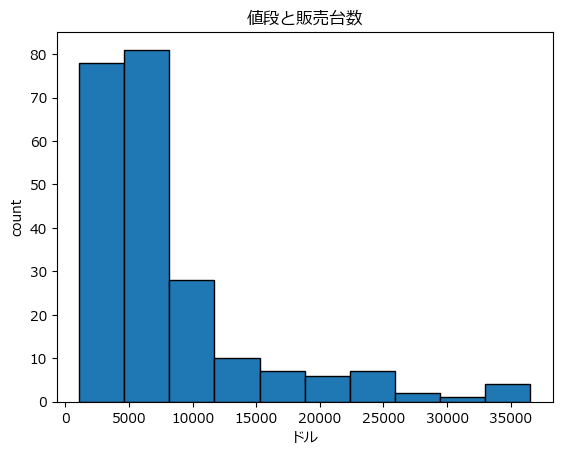

In [98]:
des('ACURA')

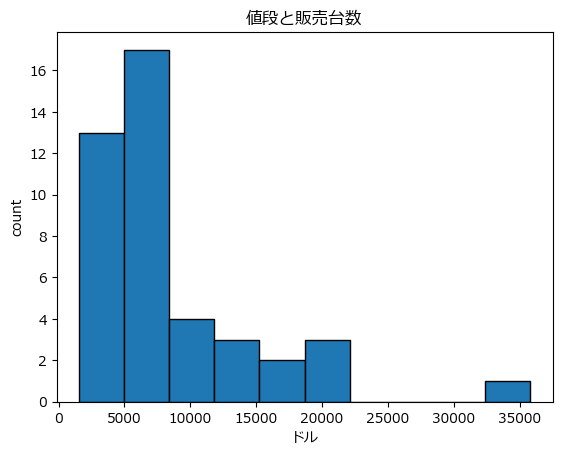

In [99]:
des('FIAT')

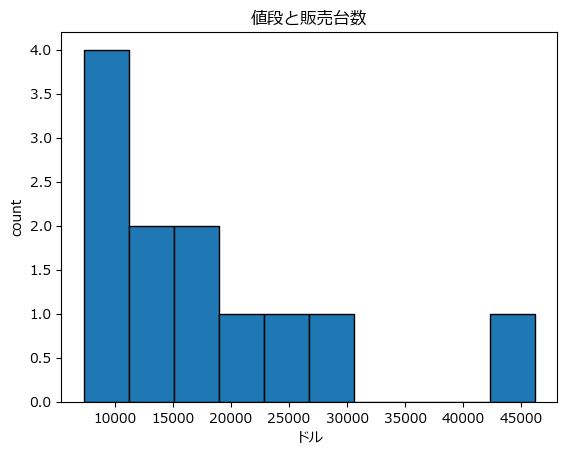

In [100]:
des('JAGUAR')

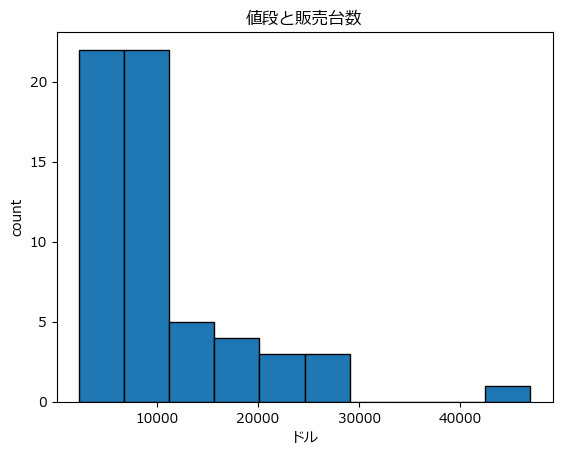

In [101]:
des('VOLVO')

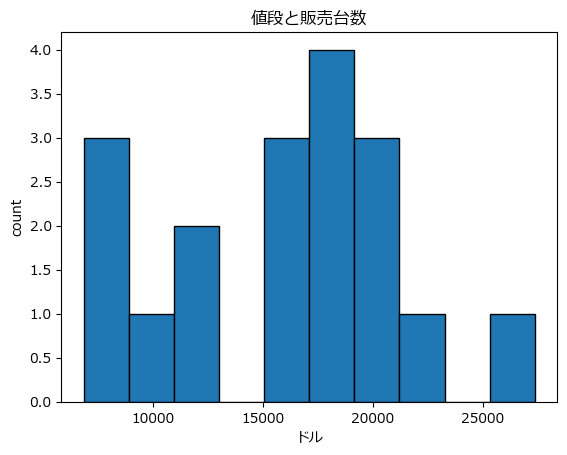

In [102]:
des('ROVER')

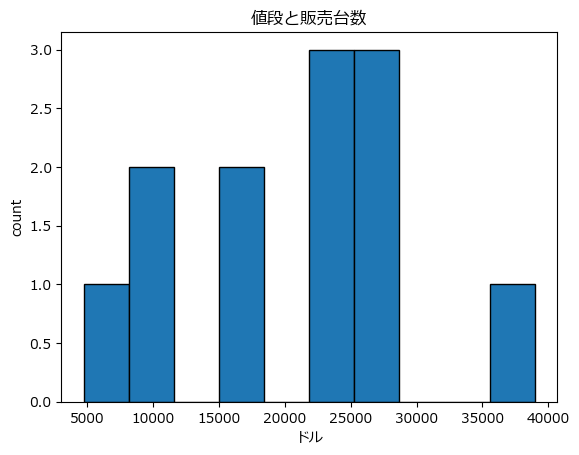

In [103]:
des('PORSCHE')

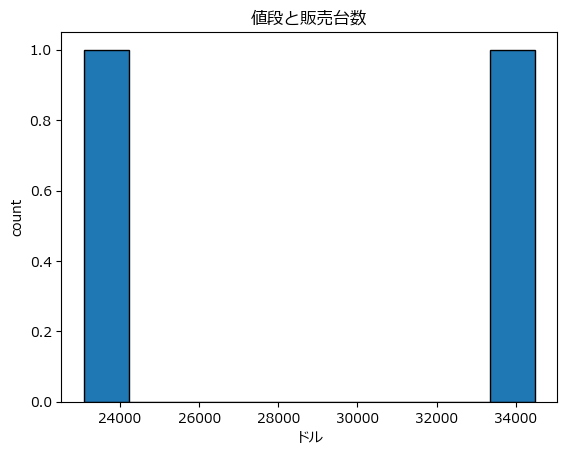

In [104]:
des('LAND ROVER')

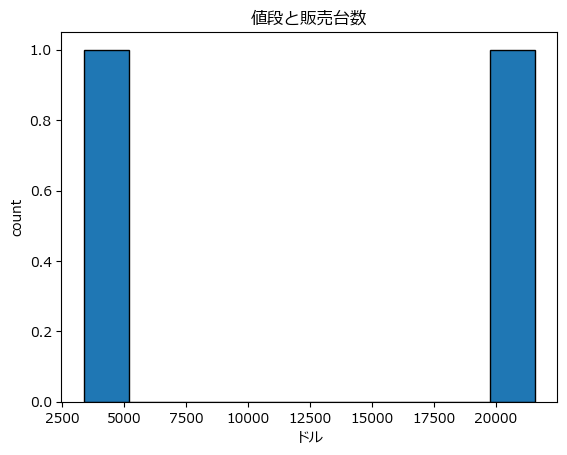

In [105]:
des('ASTON-MARTIN')

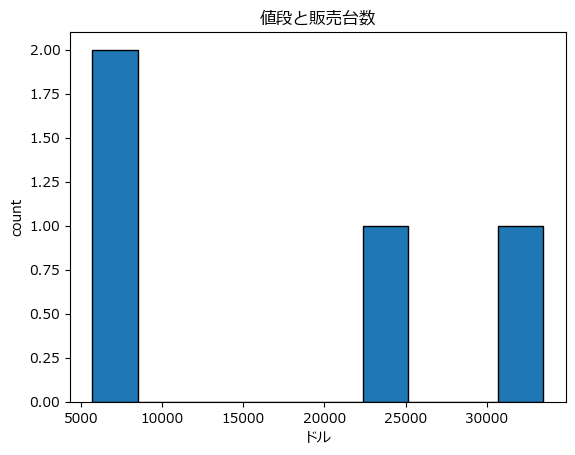

In [106]:
des('ALFA-ROMEO')